# Connectome Pipeline - HCP Brain Age data

Regression on age based on connectivity data

## 1. Preprocessing

In the first step, you will preprocess the CONN Matlab files to an analysis ready dataset.

Here is an overview on the parameters for the preprocessing pipeline. Parameters marked with a (*) are optional.


+    *matlab_dir*: path to matlab files
+    *excel_path*: path to excel list
+    *preprocessing_type*: conn for connectivity matrix or "aggregation" for aggregated conn matrix
+    *export_file**: If false return as pd dataframe
+    *write_dir**: path where to write the dataset to if save_file = True
+    *network**: Yeo7 or Yeo17 network (only applicable if preprocessing_type = aggregation)
+    *statistic**: Summary statistic to be applied (only applicable if preprocessing_type = aggregation)
+    *upper**: boolean whether only upper diagonal elements of connecivity matrices should be used
+    *file_format**: Pass "h5" for further modelling in python or "csv" for R (default "csv")

In [1]:
import os
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/Colab Notebooks/Innolab/Github')

Mounted at /content/drive


In [4]:
from connectome.preprocessing.preprocessing_matlab_files import preprocess_mat_files

In [5]:
matlab_dir = "/content/drive/MyDrive/Colab Notebooks/Innolab/data_HCP/Matlab_Files" # Enter the directory for the matlab files
excel_path = "/content/drive/MyDrive/Colab Notebooks/Innolab/data_HCP/BrainageDataset.xlsx" # Enter the directory for the corresponding excel sheet
preprocessing_type = 'conn'
write_dir = "" # ...
export_file = False # rename to export file

In [6]:
df = preprocess_mat_files(matlab_dir = matlab_dir, excel_path = excel_path, preprocessing_type = preprocessing_type,
                          write_dir = write_dir, export_file = export_file)

loading files
Starting Preprocessing
Creating Final Dataset
Done!


In [7]:
# convert sex (factor variable) to 0 (M) and 1 (F)
df.loc[df["sex"] == "M", "sex"] = 0
df.loc[df["sex"] == "F", "sex"] = 1

In [14]:
df.head()

,ConnID,interview_age,sex,IDs,1_2,1_3,1_4,1_5,1_6,1_7,...,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
0,1.0,558,1,1.0,1.070862,-0.107437,-0.10142,-0.270411,-0.04529,0.846576,...,0.630034,0.418016,0.344191,0.252702,0.295602,0.181288,0.347208,0.276222,0.081406,0.272431
1,2.0,436,1,2.0,0.649744,0.388735,-0.261952,0.208233,-0.082839,0.251986,...,0.331904,0.253022,0.005287,0.037816,0.078752,0.099308,0.136907,0.117588,0.352054,0.105746
2,3.0,544,1,3.0,0.939803,-0.091677,-0.170826,-0.003929,-0.292105,0.283715,...,0.526577,0.20863,0.018447,0.478663,0.020962,0.285674,0.553512,-0.058039,0.195715,0.292412
3,4.0,640,0,4.0,0.232634,0.302839,-0.075453,0.039461,-0.050742,0.318042,...,0.38753,0.197159,0.027587,0.194567,0.108149,0.089051,0.396254,-0.022368,0.284038,0.200894
4,5.0,725,1,5.0,0.363688,-0.087145,-0.299887,0.07974,-0.130812,0.514166,...,0.169498,0.395519,0.082053,0.089588,0.281266,0.30107,-0.037916,0.195729,0.127672,0.222499


## 2. Modelling

In the second step, you can decide between running the new input files on a pretrained model or train a new model

### 2.1  Data preparation
Preparation of the data for modelling. Creates the target variable, drops unnecessary columns, performs a train/test split (if wanted). \\
The user has to specify:
- *classification*: is it a classification task (True) or a regression task (False)
- *columns_drop*: which variables shoulnd't be used for modelling
- *target*: what is the name of the target variable
- *y_0, y_1* (only relevant for classification task): which values of the target variable are 0, which are 1
- *train_size*: size of the training data
- *seed*: a seed to ensure reproducibility of train/test split
- split: should a train/test split be performed or not? 

In [9]:
from connectome.preprocessing.data_preparation import prepare_data

In [12]:
classification = False
columns_drop = ["ConnID", "IDs"]
target = "interview_age"
train_size = 0.8
seed = 1855
split = True

In [27]:
# preparation of data
X_train, y_train, X_test, y_test = prepare_data(data = df, classification = classification,
                                                columns_drop = columns_drop, target = target, y_0 = y_0, y_1 = y_1,
                                                train_size = train_size, seed = seed, split = split)



### 2.2 Run Model or get pretrained model

Selection which model should be used and whether a pretrained model or newly trained model is desired.

You can find a selection fo pretrained models under the models folder.

The user has to specify:
- X_train: training data coming from the previous step
- y_train: values of target variable for the training data coming from the previous step
- model: which model should be used (options are: "elnet" for elastic net, "gboost" for gradient boosting, "rf" for random forest and "cnn" for convolutional neural network)
- pretrained: is a pretrained model wanted or should the training data be used to fit a new one. (True = pretrained, False = new fit)
- model_path: the full path to the desired pretrained model if one should be used

In [17]:
from connectome.models.framework import model_framework

In [ ]:
model = model_framework(X_train = X_train,
                        y_train = y_train,
                        model = "elnet",
                        pretrained = False,
                        model_path = None)

## 3. Model Evaluation

In this step you can now evaluate the Model on a set of prespecified metrics.

+ For Classification: Accuracy, Precision, Recall, F1 and AUC
+ For Regression: MSE, MAE and R2

Checkout https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics for details

In [20]:
from connectome.models.evaluation import model_evaluation
from connectome.models.brainnet_cnn import preprocess_test_data_for_cnn

In [ ]:
# If a cnn Model was trained uncomment the next line to transform the test_dataset to the right input format for the CNN with the same settings
# X_test, y_test = preprocess_test_data_for_cnn(X_test, y_test, aggregation=False, reorder=False)

In [30]:
model_evaluation(model, X_test, y_test)

,Mean Squared Error,Mean Absolute Error,Recall
0,16033.685463,104.413391,0.48544


## 4. Feature Visualization and Interpretation

In the final step you can choose between several feature visualization and interpretation techniques.

The user has to specify:
+        model: the model from  step 2
+        X: X_test dataframe
+        y: Target test dataframe
+        viz_method: Choice  of "GFI" , "GFI_only", "FI" , "FI_only", "elastic_net", "shapley" and "feature_attribution"

Visualization methods:
+ GFI: Grouped Permutation Feature Importance (based on yeo7 network) (for elastic net and random forest)
+ GFI_only: Group only Permutation Feature Importance (based on yeo7 network) (for elastic net and random forest)
+ FI: Permutation Feature Importance (for elastic net and random forest)
+ FI_only: Version of Group only Permutation Feature Importance but for every feature, not groups (for elastic net and random forest)
+ elastic_net: Visualization of the elastic net coefficients (for elastic net models only)
+ shapley: Summary plot for shapley values
+ feature_attribution: Neural Network Visulization with Saliency Maps

For more details and customization of plots see our documentation.

In [25]:
from connectome.visualization.viz_framework import visualization_framework

In [32]:
viz = visualization_framework(model=model,X=X_test,
                              y=y_test, viz_method="elastic_net")

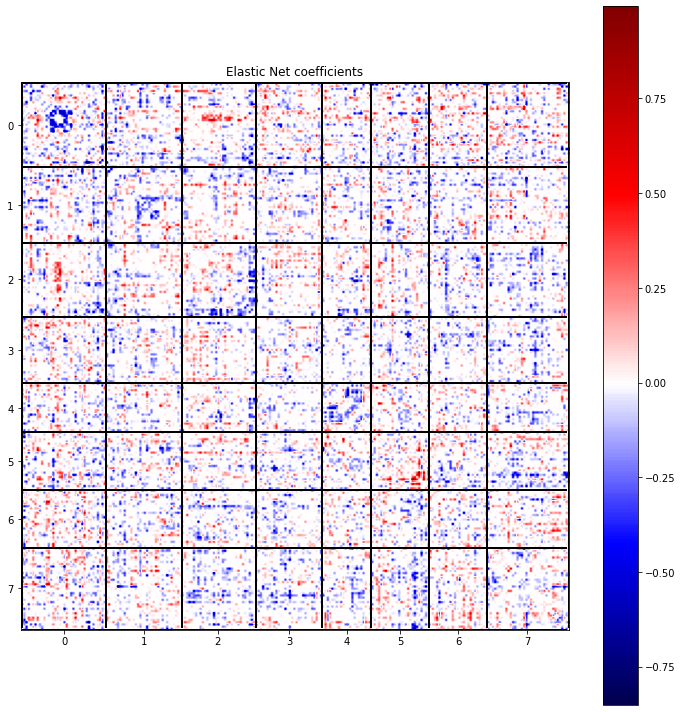

In [33]:
viz